In [1]:
import numpy as np
import random
import pandas as pd
from datetime import datetime
import time
from scipy.spatial.distance import cdist
import sys
np.set_printoptions(threshold=sys.maxsize, precision = 2)
np.set_printoptions(suppress=True)

In [2]:
from twin_graphs_generator import generate_twin_graphs
from ARG import ARG
from graph_matching import graph_matching, match_score, pre_compute_compatibility

In [323]:
def load_defect_info(i, spec):
    basedir = '/Users/siriusxiao/Library/CloudStorage/Box-Box/Shared_data_between_Zahra_and_Yunrui/Experimental_data/piv/piv_bin2_400msint_200msExp_match/channel1_region1_match/'
    # node columns: x, y, core size
    nodes = np.loadtxt(basedir + '%d_%s.csv'%(i,spec), delimiter = ',')
    
    # only use x and y 
    nodes = nodes[:,[0,1]]/50
    # normalize
#     low = np.min(nodes, axis=0)
#     high = np.max(nodes, axis=0)
#     nodes = (nodes-low)/(high-low)
    edges = np.zeros((len(nodes), len(nodes)))
    return nodes, edges

def compatibility(atr1, atr2):
    #Consider the order to return 0 or inf
    
    if np.isnan(atr1).any() or np.isnan(atr1).any():
        return 0
    if (atr1 == float('Inf')).any() or (atr2 == float('Inf')).any():
        return float('Inf')
    if len(atr1) != len(atr2):
        return 0
    if (atr1 == 0).all() or (atr2 == 0).all():
        return 0
    
    
    dim = len(atr1)
    score = 1-((atr1-atr2)**2).sum()
    #score = atr1 * atr2
    return score

def pre_compute_compatibility(ARG1, ARG2, alpha=1, stochastic=0, node_binary=True, edge_binary=True, dist_mask=None):
    '''
    Compute the best matching with two ARGs.
    
    '''
    
    # Size of the real match-in matrix
    A = ARG1.num_nodes
    I = ARG2.num_nodes
    real_size = [A, I] # ???
    augment_size = [A+1, I+1] # size of the matrix with slacks
    
    #### compute c_aibj ####
    # nil node compatibility percentage
    prct = 10
    
    ## pre-calculate the node compatibility
    C_n = np.zeros(augment_size)
    
    if node_binary:
        C_n[:A,:I] = cdist(ARG1.nodes_vector, ARG2.nodes_vector, compatibility_binary)
    else:
        C_n[:A,:I] = cdist(ARG1.nodes_vector, ARG2.nodes_vector, compatibility)
    
    # Add score to slacks
    C_n[A,:-1] =  np.percentile(C_n[:A,:I],prct,0)
    C_n[:-1,I] =  np.percentile(C_n[:A,:I],prct,1)
    C_n[A,I] = 0 

    # times the alpha weight
    C_n = alpha*C_n
    
#     print(C_n)
    
    if dist_mask is not None:
        C_n[:A,:I] = np.multiply(C_n[:A,:I], dist_mask)
    
    return C_n


In [324]:
import importlib
from sklearn.preprocessing import normalize
def graph_matching(C_n, ARG1, ARG2, beta_0=0.1, beta_f=20, beta_r=1.025, 
                   I_0=20, I_1=200, e_B=0.1, e_C=0.01, fixed_match = None):  # C_e, 
    ### fixed match is a matrix (A*I) for the pre-determined matching pairs 
    ##  We first do not consider the stochastic.
    # set up the soft assignment matrix
    
    A = C_n.shape[0] - 1
    I = C_n.shape[1] - 1 
    m_Head = np.random.rand(A+1, I+1) # Not an assignment matrix. (Normalized??)
    m_Head[-1,-1] = 0
    
    ### zero the nodes that already matched 
    if fixed_match is not None:
        print('fixed some points')
        C_n = np.multiply(C_n, fixed_match)

    # Initialization for parameters

    ## beta is the penalty parameters
    # includes beta_0, beta_f, beta_r

    ## I controls the maximum iteration for each round
    # includes I_0 and I_1

    ## e controls the range
    # includes e_B and e_C

    # begin matching
    beta = beta_0

    stochastic = False ### we first do not consider this case
    
    # the indexes of the non-zero elements in C_n
    idx1 = np.unique(C_n.nonzero()[0])
    idx2 = np.unique(C_n.nonzero()[1])  # not used, only check number
#     print(A, len(idx1))
#     print(I, len(idx2))
    
#     tmp_edges_1 = np.full([(A+1),(A+1)], np.nan)
#     tmp_edges_1[:A,:A] = ARG1.edges_matrix
#     tmp_edges_1[A,A] = float('Inf')
    
#     tmp_edges_2 = np.full([(I+1),(I+1)], np.nan)
#     tmp_edges_2[:I,:I] = ARG2.edges_matrix
#     tmp_edges_2[I,I] = float('Inf')

    while beta < beta_f:

        ## Round-B
        #check if converges
        converge_B = False
        I_B = 0
        while (not converge_B) and I_B <= I_0: # Do B until B is converge or iteration exceeds
            if stochastic:
                m_Head = m_Head ### + ???           

#             print('I_B', m_Head[0])
            old_B = m_Head # the old matrix
            I_B += 1 

            # Build the partial derivative matrix Q
            Q = np.zeros([A+1, I+1])
            
            #### only calculate Q for the indexes positions

            # Edge attribute
#             for a in idx1:
#                 ## get the non-zero (potential matches) in the second graph
#                 idx2 = np.unique(np.nonzero(C_n[a]))
#                 for i in idx2:
#                     c_e = np.zeros([A+1, I+1])
#                     edge1 = tmp_edges_1[a]
#                     edge2 = tmp_edges_2[i]
#                     c_e = np.dot(edge1, np.transpose(edge2))
#                     c_e[np.isnan(c_e)] = 0
#                     c_e[c_e == float('Inf')] = 0
#                     Q[a,i] = sum(sum(c_e*m_Head))

            # Node attribute
            Q = Q + C_n 
#             print(Q)

            # Update m_Head
            m_Head = np.exp(beta*Q) 
            m_Head[-1, -1] = 0
            
#             print(m_Head)
            
            converge_C = False
            I_C = 0
            while (not converge_C) and I_C <= I_1: # Do C until C is converge or iteration exceeds
                I_C += 1
                old_C = m_Head
                
#                 print(m_Head[0])

                # Begin alternative normalization. 
                # Do not consider the row or column of slacks
                # by column
                m_Head = normalize(m_Head, norm='l2',axis=0)*normalize(m_Head, norm='l2',axis=0)
                # By row
                m_Head = normalize(m_Head, norm='l2',axis=1)*normalize(m_Head, norm='l2',axis=1)
                
#                 print('I_C', m_Head[0])

                # print(sum(m_Head))
                # update converge_C
                converge_C = abs(sum(sum(m_Head-old_C))) < e_C

            # update converge_B
            converge_B = abs(sum(sum(m_Head[:A,:I]-old_B[:A,:I]))) < e_B
        # update beta
        beta *= beta_r

    match_matrix = heuristic(m_Head, A, I)
    #match_matrix = m_Head
    return match_matrix

def heuristic(M, A, I):
    '''
    Make a soft assignment matrix to a permutation matrix. 
    Due to some rules.
    We just set the maximum element in each column to 1 and 
    all others to 0.
    This heuristic will always return a permutation matrix 
    from a row dominant doubly stochastic matrix.
    '''
    M = normalize(M, norm='l2',axis=1)*normalize(M, norm='l2',axis=1)
    for i in range(A+1):
        index = np.argmax(M[i,:]) # Get the maximum index of each row
        M[i,:] = 0
#         if index != I-1:
#             M[:,index] = 0
#         ###
#         else:
#             print(i, I-1)
        M[i,index] = 1
    M = M[:A,:I]
    return M

In [325]:
def match_nodes(node1, node2, edge1, edge2):
    ## calculate node distance matrix (N*M)
    dist_matrix = cdist(node1, node2)
    # dist_matrix[0][2]

    ## set distance threshold
    threshold = np.percentile(dist_matrix, 5)
    print(threshold)
    dist_mask = np.where(dist_matrix>threshold, 0, 1)

    ARG1 = ARG(edge1, node1)
    ARG2 = ARG(edge2, node2)
    start_time = time.time()
    C_n = pre_compute_compatibility( ARG1, ARG2, alpha=1, stochastic=0,node_binary=False)
#     print("--- Calculate C_n,  %s hours ---" % ((time.time() - start_time)/3600))
    start_time = time.time()
    match_matrix = graph_matching(C_n=C_n, ARG1 = ARG1, ARG2 = ARG2, 
                                  beta_0=0.1, beta_f=100, beta_r=1.01, 
                                   I_0=200, I_1=200, e_B=0.00005, e_C=0.00005
                                  )
#     print("--- Matched in %s hours ---" % ((time.time() - start_time)/3600))
    
    # apply distance mask
    match_matrix = np.multiply(match_matrix, dist_mask)
    
    g1, g2 = match_matrix.nonzero()
    rslt = np.zeros([match_matrix.shape[0], 2]) # need to maintain record if one node is graph 1 is not matched
    rslt[:, 0] = np.arange(1, match_matrix.shape[0]+1)
    
    pos_xy = np.zeros([match_matrix.shape[0], 2, 2])
    pos_xy[:, 0] = node1
    
    for i in range(len(g1)):
        rslt[g1[i], 1] = g2[i] + 1
        pos_xy[g1[i], 1] = node2[g2[i]]
#     rslt = np.concatenate(((g1+1).reshape(len(g1), 1), (g2+1).reshape(len(g2), 1)), axis=1)
    return rslt, pos_xy

In [174]:
idx1 = 0
idx2 = 11
spec = 'p'
node1, edge1 = load_defect_info(idx1, spec)
node2, edge2 = load_defect_info(idx2, spec)


In [203]:
idx1 = 0
idx2 = 15
spec = 'p'
node1, edge1 = load_defect_info(idx1, spec)
node2, edge2 = load_defect_info(idx2, spec)
## calculate node distance matrix (N*M)
dist_matrix = cdist(node1, node2)
# dist_matrix[0][2]

## set distance threshold, 25%
threshold = np.percentile(dist_matrix, 10)
print(threshold)
dist_mask = np.where(dist_matrix>threshold, 0, 1)

ARG1 = ARG(edge1, node1)
ARG2 = ARG(edge2, node2)
start_time = time.time()
C_n = pre_compute_compatibility( ARG1, ARG2, alpha=1, stochastic=0,node_binary=False)
print("--- Calculate C_n,  %s hours ---" % ((time.time() - start_time)/3600))
start_time = time.time()
match_matrix = graph_matching(C_n=C_n, ARG1 = ARG1, ARG2 = ARG2, 
                              beta_0=0.1, beta_f=100, beta_r=1.01, 
                               I_0=200, I_1=200, e_B=0.00005, e_C=0.00005
                              )

match_matrix = np.multiply(match_matrix, dist_mask)
g1, g2 = match_matrix.nonzero()
rslt = np.zeros([match_matrix.shape[0], 2]) # need to maintain record if one node is graph 1 is not matched
rslt[:, 0] = np.arange(1, match_matrix.shape[0]+1)

pos_xy = np.zeros([match_matrix.shape[0], 2, 2])
pos_xy[:, 0] = node1

for i in range(len(g1)):
    rslt[g1[i], 1] = g2[i] + 1
    pos_xy[g1[i], 1] = node2[g2[i]]

3.7020641838684303
(27, 27)
(25, 25)
--- Calculate C_n,  5.578862296210395e-06 hours ---


In [186]:
node2[0]

array([ 2.06, 10.47])

In [136]:
dist_mask

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [284]:
def match_multistep(node_list, edge_list, start, step, spec):
    node1 = node_list[start]
    node2 = node_list[start + 1]
    edge1 = edge_list[start]
    edge2 = edge_list[start + 1]
    rslt1, pos1 = match_nodes(node1, node2, edge1, edge2)

    track = np.zeros([len(rslt1), step+1])
    track[:, :2] = rslt1

    track_xy = np.zeros([len(rslt1), step+1, 2])

    track_xy[:, 0, :] = pos1[:,0] # node position in the first frame
    track_xy[:, 1, :] = pos1[:,1]

    for i in range(1, step):
        node1 = node_list[start]
        node2 = node_list[start + i + 1]
        edge1 = edge_list[start]
        edge2 = edge_list[start + i + 1]
        rslt, pos = match_nodes(node1, node2, edge1, edge2)
        for pair in rslt:
            idx = np.where(track[:, 0] == pair[0])[0]
            if len(idx)>0:
                for m in idx:
                    track[m, i+1] = pair[1]
                    track_xy[m, i+1, :] = pos[m,1]
    return track, track_xy


In [252]:
start = 1
step = 2
end = 5
spec = 'p'

node_list = []
edge_list = []
for i in range(end):
    node1, edge1 = load_defect_info(i, spec)
    node_list.append(node1)
    edge_list.append(edge1)
    
track, track_xy = match_multistep(node_list, edge_list, start, step, spec)


3.8415097204977
(27, 27)
(29, 29)
--- Calculate C_n,  8.527835210164387e-06 hours ---
--- Matched in 0.0001663774914211697 hours ---
1
3.8669800664131264
(27, 27)
(25, 25)
--- Calculate C_n,  3.658731778462728e-06 hours ---
--- Matched in 0.00014324221346113418 hours ---


In [248]:
len(node_list)

5

In [253]:
track_xy

array([[[ 2.06, 10.47],
        [ 2.06, 10.46],
        [ 2.06, 10.44]],

       [[ 3.84, 12.4 ],
        [ 3.83, 12.41],
        [ 3.86, 12.43]],

       [[ 4.23,  8.58],
        [ 4.26,  8.56],
        [ 4.29,  8.55]],

       [[ 5.72, 18.95],
        [ 0.  ,  0.  ],
        [ 0.  ,  0.  ]],

       [[ 8.36,  7.91],
        [ 8.51,  7.89],
        [ 8.48,  7.84]],

       [[ 8.47, 17.82],
        [ 8.47, 17.84],
        [ 8.47, 17.85]],

       [[ 8.86,  5.24],
        [ 8.85,  5.25],
        [ 8.85,  5.22]],

       [[ 9.64, 11.7 ],
        [ 9.63, 11.72],
        [ 9.64, 11.7 ]],

       [[ 9.82,  1.34],
        [ 9.89,  1.36],
        [ 9.95,  1.52]],

       [[10.11,  1.56],
        [10.1 ,  1.59],
        [ 9.95,  1.52]],

       [[10.22, 17.79],
        [10.21, 17.75],
        [10.19, 17.69]],

       [[10.45,  7.69],
        [10.45,  7.67],
        [10.45,  7.65]],

       [[12.57,  0.14],
        [12.51,  0.08],
        [ 0.  ,  0.  ]],

       [[12.99, 19.45],
        [12.83

In [326]:
# match sequence with interpolation
start = 0
step = 2 ## how frames to match with the current one for interpolation 
spec = 'p'
end = 79

node_list = []
edge_list = []
for i in range(end + 1):
    node1, edge1 = load_defect_info(i, spec)
    node_list.append(node1)
    edge_list.append(edge1)
    
node_list_base = node_list.copy()
edge_list_base = edge_list.copy()

for i in range(end):
    if (i + step) > end:
        step = end - i
        t, t_xy = match_multistep(node_list, edge_list, i, step, spec)
    else:
        t, t_xy = match_multistep(node_list, edge_list, i, step, spec)
        mid_idx = np.where(t[:,1]==0)[0] # check if middle frame is not matched
        if len(mid_idx)>0:
            # check if both the end frame is matched, if so, interpolate mid frame and save
            for idx in mid_idx:
                if t[idx][2] != 0: #matched
#                     print(i, idx)
                    mid_frame = node_list[i+1]
                    N = len(mid_frame) # number of nodes
                    x1, y1 = t_xy[idx][0]
                    x2, y2 = t_xy[idx][2]
                    x = (x1 + x2)/2
                    y = (y1 + y2)/2
                    mid_frame = np.concatenate((mid_frame, np.array([[x, y]])))
                    node_list[i+1] = mid_frame # put the updated frame back to the list
                    edge_list[i+1] = np.zeros((len(mid_frame), len(mid_frame)))
                    
        
    

2.248577207181521
(27, 27)
(27, 27)
2.1913208595711744
(27, 27)
(29, 29)
0 11
2.388534559317015
(28, 28)
(29, 29)
2.1766737133697087
(28, 28)
(25, 25)
2.169025599118328
(29, 29)
(25, 25)
2.275190458619148
(29, 29)
(26, 26)
2 11
2 12
2.1574953986101373
(27, 27)
(26, 26)
2.1684863748776477
(27, 27)
(28, 28)
3 23
2.1665062459110587
(27, 27)
(28, 28)
2.2232245425395036
(27, 27)
(27, 27)
2.312002908019801
(28, 28)
(27, 27)
2.351109828114969
(28, 28)
(25, 25)
5 10
2.198931316114062
(28, 28)
(25, 25)
2.3361855939066056
(28, 28)
(28, 28)
6 11
6 16
2.3783475749788106
(27, 27)
(28, 28)
2.2346095373221693
(27, 27)
(24, 24)
2.2547308656832046
(28, 28)
(24, 24)
2.3343936752367904
(28, 28)
(25, 25)
8 0
8 12
2.18763504963327
(26, 26)
(25, 25)
2.1639411166394638
(26, 26)
(25, 25)
2.17061361366712
(25, 25)
(25, 25)
2.285855798453778
(25, 25)
(24, 24)
2.1879174087310687
(25, 25)
(24, 24)
2.2451929175835623
(25, 25)
(25, 25)
2.230268602035147
(24, 24)
(25, 25)
2.289588625632798
(24, 24)
(26, 26)
2.315657

In [340]:
# after matching, the node list should be interpolated. 
# match neighbor frames and record matching sequencially from beginning frame to end 
def match_all_frames(node_list, edge_list, start, end, spec):
    node1 = node_list[start]
    node2 = node_list[start + 1]
    edge1 = edge_list[start]
    edge2 = edge_list[start + 1]
    rslt1, pos1 = match_nodes(node1, node2, edge1, edge2)

    track = np.zeros([len(rslt1), end+1])
    track[:, :2] = rslt1

    track_xy = np.zeros([len(rslt1), end+1, 2])

    track_xy[:, 0, :] = pos1[:,0] # node position in the first frame
    track_xy[:, 1, :] = pos1[:,1]

    for i in range(start+1, end):
        node1 = node_list[i]
        node2 = node_list[i + 1]
        edge1 = edge_list[i]
        edge2 = edge_list[i + 1]
        rslt, pos = match_nodes(node1, node2, edge1, edge2)
        for j, pair in enumerate(rslt):
            idx = np.where(track[:, i] == pair[0])[0]
            if len(idx)>0:
                for m in idx:
                    track[m, i+1] = pair[1]
                    track_xy[m, i+1, :] = pos[j,1]
    return track, track_xy
    
track, track_xy = match_all_frames(node_list, edge_list, 0, 79, spec)
    

2.1652301862202066
(27, 27)
(28, 28)
2.388534559317015
(28, 28)
(29, 29)
2.1685652752262774
(29, 29)
(27, 27)
2.127669503221181
(27, 27)
(27, 27)
2.1665062459110587
(27, 27)
(28, 28)
2.2060606145232216
(28, 28)
(28, 28)
2.2980764790499992
(28, 28)
(27, 27)
2.3783475749788106
(27, 27)
(28, 28)
2.2871336607558965
(28, 28)
(26, 26)
2.18763504963327
(26, 26)
(25, 25)
2.17061361366712
(25, 25)
(25, 25)
2.1879174087310687
(25, 25)
(24, 24)
2.230268602035147
(24, 24)
(25, 25)
2.3156579525595493
(25, 25)
(26, 26)
2.297354642443038
(26, 26)
(27, 27)
2.315307222409177
(27, 27)
(27, 27)
2.3894844540141382
(27, 27)
(27, 27)
2.2833713296446736
(27, 27)
(27, 27)
2.2890686938744036
(27, 27)
(24, 24)
2.152942624321765
(24, 24)
(24, 24)
2.209822074179551
(24, 24)
(25, 25)
2.512361597067373
(25, 25)
(26, 26)
2.511375642895156
(26, 26)
(24, 24)
2.1610422988032196
(24, 24)
(24, 24)
2.1819495867384964
(24, 24)
(23, 23)
2.218214986770044
(23, 23)
(23, 23)
2.2044248490341616
(23, 23)
(24, 24)
2.1512920392643

In [345]:
np.savetxt('/Users/siriusxiao/Library/CloudStorage/Box-Box/Shared_data_between_Zahra_and_Yunrui/Experimental_data/piv/piv_bin2_400msint_200msExp_match/channel1_region1_match_rslt/positive/track_intp_80.csv',track, delimiter=',')

In [346]:
# save movement of each node
for i in range(track_xy.shape[0]):
    np.savetxt('/Users/siriusxiao/Library/CloudStorage/Box-Box/Shared_data_between_Zahra_and_Yunrui/Experimental_data/piv/piv_bin2_400msint_200msExp_match/channel1_region1_match_rslt/positive/track_xy_intp_80_%0.2d.csv'%i, track_xy[i], delimiter=',')

In [343]:
track_xy.shape

(27, 80, 2)

In [333]:
node_list[16]

array([[ 2.06, 10.67],
       [ 3.99, 12.35],
       [ 4.11,  8.55],
       [ 8.12,  7.85],
       [ 8.47, 17.8 ],
       [ 8.64,  5.22],
       [ 9.79,  1.22],
       [ 9.78, 11.66],
       [10.16, 17.51],
       [10.45,  7.41],
       [12.71,  0.25],
       [13.02, 19.43],
       [13.75, 14.93],
       [14.35,  9.71],
       [15.83, 19.14],
       [16.7 ,  5.57],
       [16.88,  1.12],
       [17.03,  8.18],
       [17.96, 12.63],
       [18.85,  9.37],
       [19.05, 17.09],
       [19.24, 10.84],
       [19.64,  5.78],
       [21.62, 15.82],
       [22.44, 15.67],
       [23.21, 11.39],
       [16.35, 16.05]])

In [335]:
match_multistep(node_list, edge_list, 14, 2, spec)

2.297354642443038
(26, 26)
(27, 27)
2.3627516949713443
(26, 26)
(27, 27)


(array([[ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5., 26.,  5.],
        [ 6.,  5.,  6.],
        [ 7.,  6.,  7.],
        [ 8.,  7.,  8.],
        [ 9., 27.,  7.],
        [10.,  8.,  9.],
        [11.,  9., 10.],
        [12., 10., 12.],
        [13., 11., 13.],
        [14., 12., 14.],
        [15., 13., 15.],
        [16., 14., 27.],
        [17., 15., 16.],
        [18., 16., 17.],
        [19., 17., 18.],
        [20., 18., 19.],
        [21., 19., 20.],
        [22., 20., 21.],
        [23., 21., 22.],
        [24., 22., 23.],
        [25., 23., 24.],
        [26., 25., 26.]]),
 array([[[ 2.06, 10.56],
         [ 2.06, 10.58],
         [ 2.06, 10.67]],
 
        [[ 3.99, 12.35],
         [ 4.03, 12.36],
         [ 3.99, 12.35]],
 
        [[ 4.15,  8.53],
         [ 4.14,  8.54],
         [ 4.11,  8.55]],
 
        [[ 8.08,  8.05],
         [ 8.12,  7.88],
         [ 8.12,  7.85]],
 
        [[ 8.47, 17.85],
         [ 

In [257]:
x, y = track_xy[a[0]][0]
x

10.4524

In [140]:
np.savetxt('track_positive_piv_region_dist.csv',track, delimiter = ',')

In [166]:
track

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  3.,  3.,  3.,
         3., 

In [197]:
track_xy[2]

array([[ 4.22,  8.58],
       [ 4.23,  8.58],
       [ 4.26,  8.56],
       [ 4.29,  8.55],
       [ 4.24,  8.54],
       [ 4.24,  8.56],
       [ 4.2 ,  8.56],
       [ 4.25,  8.54],
       [ 4.22,  8.56],
       [ 4.2 ,  8.54],
       [ 4.22,  8.53],
       [ 4.16,  8.55],
       [ 4.19,  8.54],
       [ 4.18,  8.53],
       [ 4.15,  8.53],
       [ 4.14,  8.54],
       [ 4.11,  8.55],
       [ 4.12,  8.52],
       [ 4.11,  8.53],
       [ 4.14,  8.52],
       [ 4.09,  8.53],
       [ 4.06,  8.54],
       [ 4.06,  8.52],
       [ 4.02,  8.54],
       [ 4.  ,  8.56],
       [ 4.01,  8.54],
       [ 4.01,  8.54],
       [ 3.99,  8.54],
       [ 3.97,  8.55],
       [ 3.95,  8.55],
       [ 3.93,  8.54],
       [ 3.93,  8.53],
       [ 3.92,  8.54],
       [ 3.9 ,  8.55],
       [ 3.86,  8.54],
       [ 3.87,  8.54],
       [ 3.86,  8.54],
       [ 3.84,  8.54],
       [ 3.8 ,  8.56],
       [ 3.81,  8.54],
       [ 3.79,  8.54],
       [ 3.74,  8.57],
       [ 3.73,  8.56],
       [ 3.

In [204]:
node1[2]

array([4.22, 8.58])

In [205]:
node2[2]

array([4.14, 8.54])

In [258]:
node1, edge1 = load_defect_info(0, 'p')

node2, edge2 = load_defect_info(2, 'p')

In [261]:
ARG1 = ARG(edge1, node1)
ARG2 = ARG(edge2, node2)

(27, 27)
(29, 29)


In [262]:
start_time = time.time()
C_n = pre_compute_compatibility( ARG1, ARG2, alpha=1, stochastic=0,node_binary=False)
print("--- %s hours ---" % ((time.time() - start_time)/3600))

--- 6.645255618625217e-06 hours ---


In [254]:
C_n[0]

array([   1.  ,   -5.81,   -7.32,  -83.99,  -45.29,  -93.79,  -72.82,
        -57.92, -142.95, -143.5 , -118.8 ,  -77.27, -216.58, -198.86,
       -155.  , -158.36, -269.86, -228.95, -308.41, -229.43, -259.53,
       -327.13, -287.23, -299.12, -324.95, -407.93, -450.23, -325.82])

In [210]:
ARG1.edges_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [264]:
start_time = time.time()
match_matrix = graph_matching(C_n=C_n, ARG1 = ARG1, ARG2 = ARG2, 
                              beta_0=0.1, beta_f=100, beta_r=1.01, 
                               I_0=200, I_1=200, e_B=0.00005, e_C=0.00005
                              )
print("--- %s hours ---" % ((time.time() - start_time)/3600))

--- 0.00011640250682830811 hours ---


In [265]:
g1, g2 = match_matrix.nonzero()
rslt = np.concatenate(((g1+1).reshape(len(g1), 1), (g2+1).reshape(len(g2), 1)), axis=1)
rslt

array([[ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  5],
       [ 5,  4],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10],
       [11, 11],
       [12, 12],
       [13, 13],
       [14, 14],
       [15, 15],
       [16, 16],
       [17, 17],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [22, 23],
       [23, 24],
       [24, 25],
       [25, 26],
       [26, 27],
       [27, 29]])

In [245]:
g2

array([ 1,  2,  4,  3,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 28])

## save result, C_n, C_e

In [11]:
outdir = '/Users/siriusxiao/Library/CloudStorage/Box-Box/PhD/ActinActiveMaterials-main/graph_matching/rslt/C_n/'
filename = 'C_n_6_4_601602_p3_400_500_400_500_new_nodegree'
np.savetxt(outdir+filename+'.csv', C_n, delimiter = ',',fmt='%f')


In [12]:
outdir = '/Users/siriusxiao/Library/CloudStorage/Box-Box/PhD/ActinActiveMaterials-main/graph_matching/rslt/'
filename = 'rslt_new_6_4_601602_p3_400_500_400_500_noce_nodegree'
np.savetxt(outdir+filename+'.csv', rslt_clean, delimiter = ',',fmt='%d')
# rslt

## After all results are saved, run this part

In [23]:
from PIL import Image

a = Image.open('/Users/siriusxiao/Library/CloudStorage/Box-Box/Shared_data_between_Zahra_and_Yunrui/Experimental_data/piv/piv_bin2_400msint_200msExp/channel1_region1/img_channel000_position000_time000000000_z000.tif')
a.mode = 'I'


In [26]:
a.size

(1280, 1080)

In [27]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = mask.astype(int)
    return mask

In [33]:
mask = create_circular_mask(a.size[1], a.size[0])

In [34]:
mask.shape

(1080, 1280)

In [84]:
high1 = np.max(a)
high2 = np.percentile(a, 99)
hi = 0.05 * high1 + 0.95 * high2
lo = np.min(a)
a2 = Image.fromarray(np.uint8((a - lo) / (hi - lo) * 255))

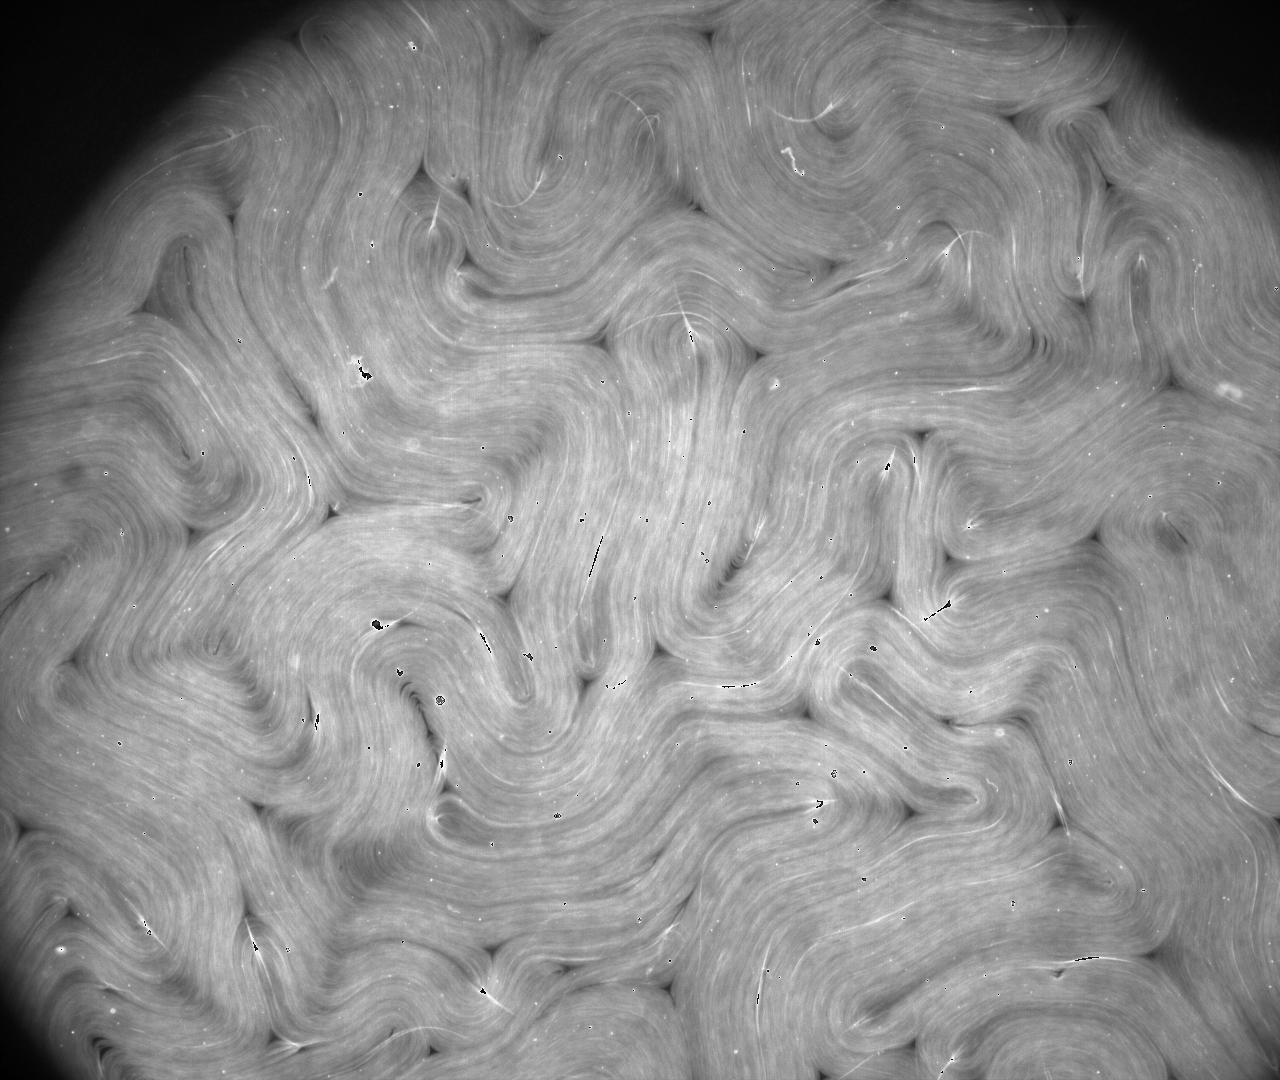

In [85]:
a2

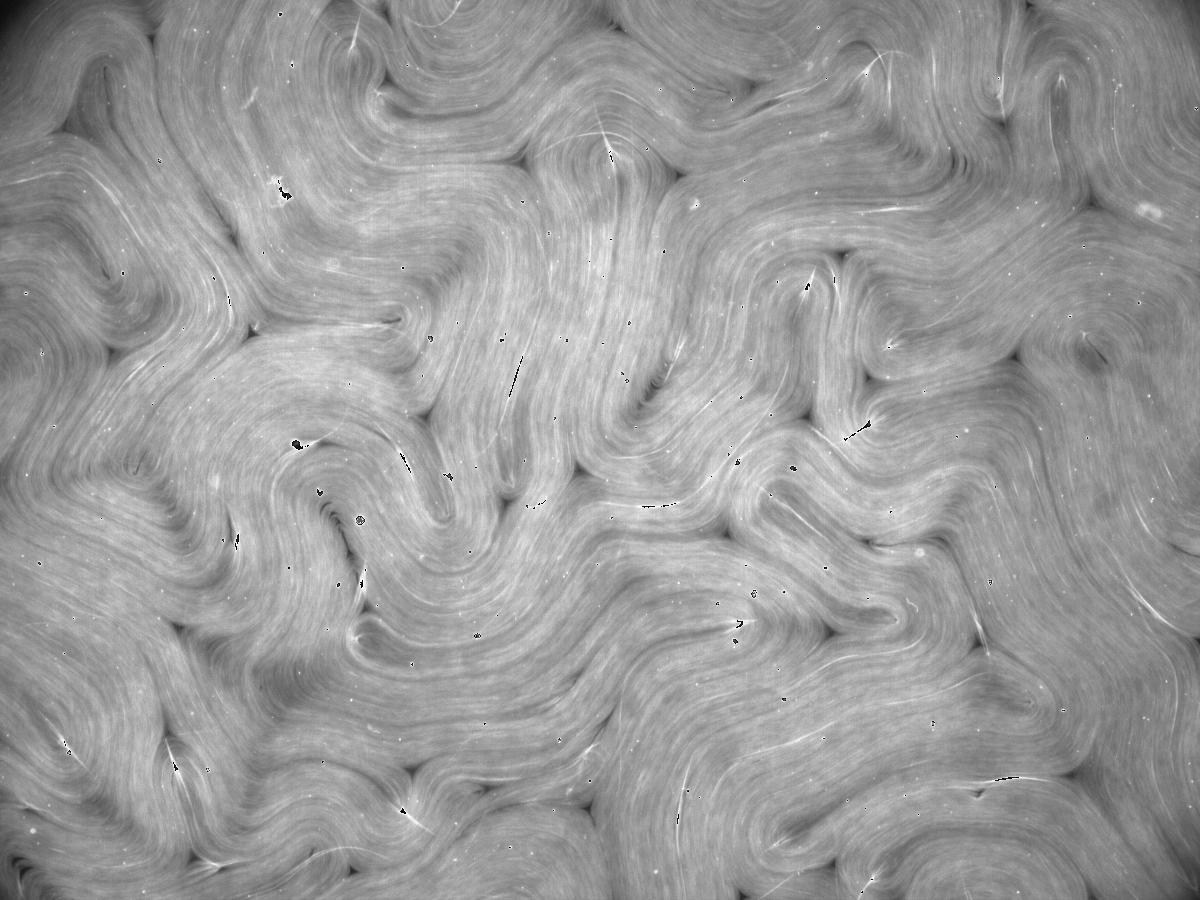

In [86]:
a2=a2.crop((80, 180, 1280,1080))
a2

In [87]:
a2.size

(1200, 900)

In [39]:
create_circular_mask(10,12)


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [273]:
a = np.zeros([4,2])

In [267]:
a

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [275]:
a[0,1] = 1
a[3,1] = 1
a[2,] = 1

In [269]:
a

array([[0., 1.],
       [0., 0.],
       [1., 1.],
       [0., 1.]])

In [274]:
np.where(np.all(a==0, axis=1))[0]

array([0, 1, 2, 3])

In [280]:
i = np.where(a[:, 1]==1)[0]

In [286]:
a[i][:,1]

array([1., 1., 1.])

In [282]:
np.mean(a[i], axis=0)

array([0.33, 1.  ])

In [284]:
i

array([0, 2, 3])

In [41]:
from torchvision import transforms
import torch

In [46]:
a = torch.rand([1,4,4])
b = torch.rand([1,4,4])
c = torch.cat([a,b], dim=0)

In [47]:
a


tensor([[[0.3161, 0.1601, 0.7301, 0.7985],
         [0.5114, 0.6432, 0.9083, 0.8336],
         [0.7610, 0.6412, 0.9224, 0.1811],
         [0.4931, 0.3470, 0.6921, 0.2034]]])

In [48]:
b

tensor([[[0.6942, 0.6101, 0.1289, 0.4742],
         [0.5458, 0.1743, 0.4035, 0.6091],
         [0.4531, 0.4338, 0.1798, 0.8279],
         [0.6216, 0.7775, 0.9331, 0.0372]]])

In [49]:
c

tensor([[[0.3161, 0.1601, 0.7301, 0.7985],
         [0.5114, 0.6432, 0.9083, 0.8336],
         [0.7610, 0.6412, 0.9224, 0.1811],
         [0.4931, 0.3470, 0.6921, 0.2034]],

        [[0.6942, 0.6101, 0.1289, 0.4742],
         [0.5458, 0.1743, 0.4035, 0.6091],
         [0.4531, 0.4338, 0.1798, 0.8279],
         [0.6216, 0.7775, 0.9331, 0.0372]]])

In [62]:
transforms.GaussianBlur(kernel_size=(3, 3), sigma=1.0)(a)

tensor([[[-0.0997, -0.0854, -0.0556, -0.0479, -0.0765, -0.1214, -0.1277,
          -0.0963, -0.0645, -0.0590],
         [-0.0997, -0.0854, -0.0556, -0.0479, -0.0765, -0.1214, -0.1277,
          -0.0963, -0.0645, -0.0590],
         [-0.0997, -0.0854, -0.0556, -0.0479, -0.0765, -0.1214, -0.1277,
          -0.0963, -0.0645, -0.0590],
         [-0.0997, -0.0854, -0.0556, -0.0479, -0.0765, -0.1214, -0.1277,
          -0.0963, -0.0645, -0.0590]]])

In [55]:
transforms.GaussianBlur(kernel_size=(3, 3), sigma=1.0)(c)

tensor([[[0.4241, 0.5348, 0.7146, 0.8232],
         [0.5175, 0.6114, 0.7067, 0.7647],
         [0.5873, 0.6577, 0.6406, 0.6343],
         [0.5678, 0.6293, 0.5615, 0.5349]],

        [[0.4804, 0.4123, 0.3782, 0.4008],
         [0.4535, 0.3918, 0.3939, 0.4319],
         [0.4875, 0.4729, 0.4785, 0.4944],
         [0.5621, 0.5538, 0.5255, 0.4978]]])

In [60]:
a = torch.tensor([[[-0.1130, -0.0888, -0.0523, -0.0277, -0.0767, -0.1249, -0.1604,
          -0.0767, -0.0645, -0.0523],
                 [-0.1130, -0.0888, -0.0523, -0.0277, -0.0767, -0.1249, -0.1604,
          -0.0767, -0.0645, -0.0523],
                 [-0.1130, -0.0888, -0.0523, -0.0277, -0.0767, -0.1249, -0.1604,
          -0.0767, -0.0645, -0.0523],
                 [-0.1130, -0.0888, -0.0523, -0.0277, -0.0767, -0.1249, -0.1604,
          -0.0767, -0.0645, -0.0523]]])

In [92]:
a = np.loadtxt('/Users/siriusxiao/Library/CloudStorage/Box-Box/PhD/ActiveNematics/code/targets_qxx.csv', delimiter = ',')
b = torch.tensor(a).unsqueeze(0)
b = b.unsqueeze(0)
b.shape


torch.Size([1, 1, 320, 320])

In [93]:
bb=transforms.GaussianBlur(kernel_size=(5,5), sigma=1.0)(b)

In [94]:
c = np.loadtxt('/Users/siriusxiao/Library/CloudStorage/Box-Box/PhD/ActiveNematics/code/targets_qxy.csv', delimiter = ',')
d = torch.tensor(c).unsqueeze(0)
d = d.unsqueeze(0)
d.shape

torch.Size([1, 1, 320, 320])

In [95]:
dd=transforms.GaussianBlur(kernel_size=(5,5), sigma=1.0)(d)

In [96]:
s = 2 * torch.sqrt(torch.pow(bb, 2) + torch.pow(dd, 2))

In [97]:
s

tensor([[[[1.2546, 1.2408, 1.2069,  ..., 0.9845, 0.9543, 0.9397],
          [1.2686, 1.2553, 1.2216,  ..., 0.9851, 0.9535, 0.9372],
          [1.2891, 1.2766, 1.2437,  ..., 0.9890, 0.9591, 0.9425],
          ...,
          [0.7295, 0.7324, 0.7379,  ..., 0.7524, 0.7939, 0.8104],
          [0.7560, 0.7580, 0.7602,  ..., 0.7725, 0.8137, 0.8291],
          [0.7689, 0.7703, 0.7707,  ..., 0.7784, 0.8171, 0.8312]]]],
       dtype=torch.float64)

In [83]:
bbb = torch.cat([b,b], dim=0)

In [84]:
transforms.GaussianBlur(kernel_size=(5,5), sigma=1.0)(bbb)

tensor([[[[-0.3844, -0.3734, -0.3457,  ...,  0.0968,  0.0755,  0.0656],
          [-0.3965, -0.3854, -0.3573,  ...,  0.0891,  0.0692,  0.0604],
          [-0.4164, -0.4053, -0.3772,  ...,  0.0783,  0.0640,  0.0581],
          ...,
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823],
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823],
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823]]],


        [[[-0.3844, -0.3734, -0.3457,  ...,  0.0968,  0.0755,  0.0656],
          [-0.3965, -0.3854, -0.3573,  ...,  0.0891,  0.0692,  0.0604],
          [-0.4164, -0.4053, -0.3772,  ...,  0.0783,  0.0640,  0.0581],
          ...,
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823],
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823],
          [-0.0767, -0.0767, -0.0767,  ...,  0.2853,  0.2839,  0.2823]]]],
       dtype=torch.float64)

In [98]:
a=torch.rand([1,3,3])
b = torch.rand([1,3,3])
a

tensor([[[0.7532, 0.5004, 0.2540],
         [0.1283, 0.6511, 0.7319],
         [0.1124, 0.8029, 0.4348]]])

In [99]:
b

tensor([[[0.2336, 0.7653, 0.0290],
         [0.3880, 0.2102, 0.8112],
         [0.4929, 0.7583, 0.6177]]])

In [101]:
(a*b).shape

torch.Size([1, 3, 3])

In [141]:
for i in range(5,3):
    print(i)